<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/hire_2%2Bindices%2B%5Bdsm%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio


In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Load RGB image
rgb = rasterio.open("/content/RGB.tif")

# Load habitat map (vector)
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

In [ ]:
# Reproject habitat to match RGB CRS
habitat = habitat.to_crs(rgb.crs)

In [ ]:
out_image, out_transform = mask(rgb, habitat.geometry, crop=True)

In [ ]:
out_meta = rgb.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [ ]:
with rasterio.open("clipped_rgb.tif", "w", **out_meta) as dest:
    dest.write(out_image)

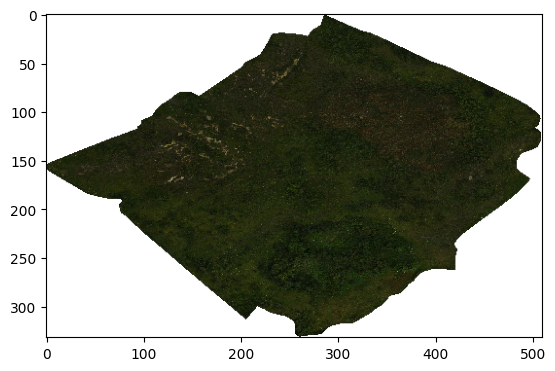

In [ ]:
import matplotlib.pyplot as plt

with rasterio.open("clipped_rgb.tif") as src:
    plt.imshow(src.read().transpose((1, 2, 0)))
    plt.show()

2 classes + indices

In [ ]:
# Load habitat vector
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

# Load raster to get CRS
with rasterio.open("clipped_rgb.tif") as src:
    raster_crs = src.crs
    profile = src.profile
    transform = src.transform
    shape = (src.height, src.width)
    img = src.read()  # shape: (bands, rows, cols)

# Reproject habitat to raster CRS
if habitat.crs != raster_crs:
    habitat = habitat.to_crs(raster_crs)
    print("Reprojected habitat shapefile to match raster CRS.")
else:
    print("CRS already matches.")

Reprojected habitat shapefile to match raster CRS.


In [ ]:
if habitat.crs != raster_crs:
    habitat = habitat.to_crs(raster_crs)
    print("Reprojected habitat shapefile to match raster CRS.")
else:
    print("CRS already matches.")

CRS already matches.


In [ ]:
class_names = [
    "Transition mire and quaking bog",
    "Rich fen and flush",
    "Rich fen and flush/Transition mire and quaking bog",
    "Raised bog",
    "Marsh",
    "Scrub/Dry meadows and grassy verges",
    "Transition mire and quaking bog/Marsh",
    "Scrub/Cutover bog"
]

class_mapping = {name: i+1 for i, name in enumerate(class_names)}
habitat["class_id"] = habitat["FossittTyp"].map(class_mapping)

In [ ]:
habitat_raster = rasterize(
    [(geom, value) for geom, value in zip(habitat.geometry, habitat["class_id"])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="int32"
)

In [ ]:
n_bands, rows, cols = img.shape
X = img.reshape(n_bands, rows * cols).T
y_labels = habitat_raster.flatten()

mask = y_labels > 0
X = X[mask]
y_labels = y_labels[mask]

In [ ]:
wetland_classes = [
    "Transition mire and quaking bog",
    "Rich fen and flush",
    "Raised bog",
    "Marsh",
    "Rich fen and flush/Transition mire and quaking bog",
    "Transition mire and quaking bog/Marsh"
]
scrub_classes = [
    "Scrub/Dry meadows and grassy verges",
    "Scrub/Cutover bog"
]

wetland_ids = [class_mapping[c] for c in wetland_classes]
scrub_ids = [class_mapping[c] for c in scrub_classes]

broad_groups = np.where(np.isin(y_labels, wetland_ids), 1, 2)

In [ ]:
print(wetland_classes)
print(scrub_classes)


['Transition mire and quaking bog', 'Rich fen and flush', 'Raised bog', 'Marsh', 'Rich fen and flush/Transition mire and quaking bog', 'Transition mire and quaking bog/Marsh']
['Scrub/Dry meadows and grassy verges', 'Scrub/Cutover bog']


In [ ]:
Blue, Green, Red, NIR = X[:,0], X[:,1], X[:,2], X[:,3]

In [ ]:
NDVI = (NIR - Red) / (NIR + Red + 1e-10)
RVI = NIR / (Red + 1e-10)
SAVI = (1.5 * (NIR - Red)) / (NIR + Red + 0.5 + 1e-10)  # L=0.5
EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
GNDVI = (NIR - Green) / (NIR + Green + 1e-10)
GRVI = (Green - Red) / (Green + Red + 1e-10)
NRVI = ((Red / (NIR + 1e-10)) - 1) / ((Red / (NIR + 1e-10)) + 1)
NDWI = (Green - NIR) / (Green + NIR + 1e-10)

In [ ]:
#stack indices with features
X_with_indices = np.column_stack([
    X, NDVI, RVI, SAVI, EVI, GNDVI, GRVI, NRVI, NDWI
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_indices, broad_groups, test_size=0.3, random_state=42, stratify=broad_groups
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.694390099640566

Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.73      0.79     17684
           2       0.33      0.54      0.41      4295

    accuracy                           0.69     21979
   macro avg       0.60      0.64      0.60     21979
weighted avg       0.76      0.69      0.72     21979


Confusion Matrix:
 [[12947  4737]
 [ 1980  2315]]


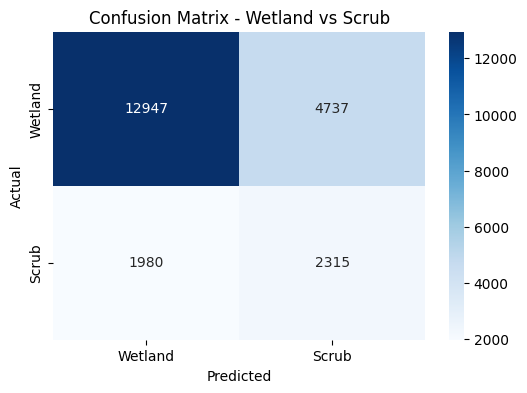

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Wetland","Scrub"],
            yticklabels=["Wetland","Scrub"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Wetland vs Scrub")
plt.show()

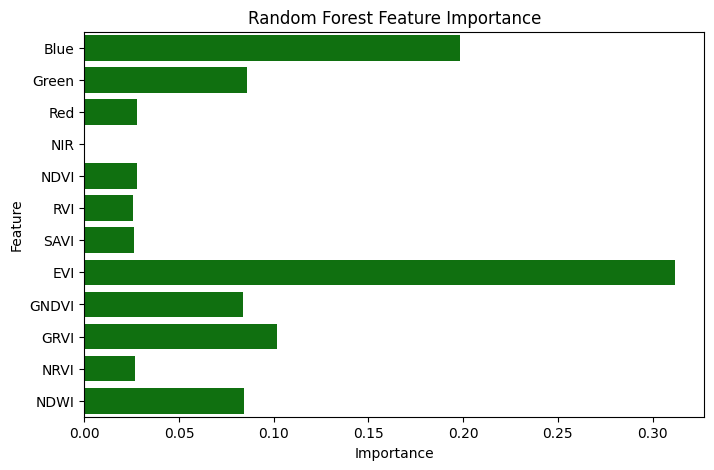

In [ ]:
import pandas as pd

# Create DataFrame for plotting
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature", color="green")
plt.title("Random Forest Feature Importance")
plt.show()


smote


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_indices, broad_groups, test_size=0.3, random_state=42, stratify=broad_groups
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set shape:", np.bincount(y_train))
print("Resampled training set shape:", np.bincount(y_train_resampled))

Original training set shape: [    0 41260 10022]
Resampled training set shape: [    0 41260 41260]


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7229628281541471

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.79      0.82     17684
           2       0.34      0.46      0.39      4295

    accuracy                           0.72     21979
   macro avg       0.60      0.62      0.61     21979
weighted avg       0.76      0.72      0.74     21979


Confusion Matrix:
 [[13904  3780]
 [ 2309  1986]]


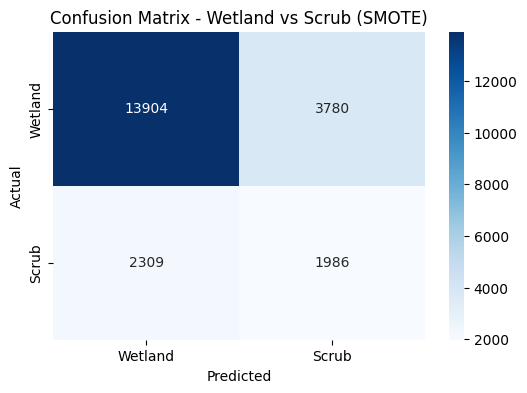

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Wetland","Scrub"],
            yticklabels=["Wetland","Scrub"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Wetland vs Scrub (SMOTE)")
plt.show()

balance accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# After predictions
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

Balanced Accuracy: 0.6243227963479414


.


DSM